<p align="center">
    <img src="title_image.png" width="65%" style="border-radius: 12px;">
</p>

<h1 style="text-align:center; font-family:Segoe UI, sans-serif; color:#ba0707;">
🩺 Healthcare Provider Fraud Detection
</h1>

<p style="text-align:center; font-size:16px;">
A real-world healthcare fraud detection system using claim-level and provider-level Medicare data.  
Built with robust preprocessing, provider-level feature aggregation, machine learning modeling, and interpretability via SHAP.  
Designed to help reduce misuse of funds and flag suspicious providers in large-scale claim datasets.
</p>

<hr>

<p style="text-align:center; font-size:15px;">
<strong>Author:</strong> Abdullah Shahzad &nbsp; | &nbsp;
<a href="mailto:abdullahshahzadhunjra@gmail.com">📧 abdullahshahzadhunjra@gmail.com</a> &nbsp; | &nbsp;
<a href="https://www.linkedin.com/in/abdullahhunjra" target="_blank">🔗 LinkedIn</a> &nbsp; | &nbsp;
<a href="https://github.com/abdullahhunjra" target="_blank">💻 GitHub</a>
</p>


# 🏥 Healthcare Provider Fraud Detection

## 📌 Project Overview

This project aims to detect potentially fraudulent healthcare providers using real-world Medicare claims data. Fraudulent billing practices pose significant risks to public health systems — identifying these behaviors early can save millions in healthcare costs and improve patient care.

The project uses structured claims, provider, and beneficiary-level data to engineer insightful features, train machine learning classifiers, and interpret results using SHAP.

---

## 🎯 Project Goals

- Identify fraudulent providers from structured claim data
- Handle real-world data challenges like missing values, outliers, and class imbalance
- Build an end-to-end machine learning pipeline with robust preprocessing
- Interpret model predictions using explainability tools

---

## 🧠 Key Tasks

- Data cleaning and merging from multiple sources
- Aggregating instance-level claims to provider-level features
- Feature engineering from medical and administrative codes
- Missing value imputation (IterativeImputer)
- Scaling (RobustScaler) and outlier consideration
- Model training: Random Forest, Gradient Boosting, Logistic Regression
- Model interpretation: SHAP
- Prediction on unseen providers (test data)


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


import joblib


# Suppress warnings for cleaner output
import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## 📦 Data Overview

We have four main files:

- `Inpatient.csv`: Hospital-based claims per patient
- `Outpatient.csv`: Ambulatory and clinical claims
- `Beneficiary.csv`: Patient demographic and chronic condition info
- `Train.csv`: Fraud labels for providers (binary classification)


In [60]:
train_inpatient = pd.read_csv('csv_files/Train_Inpatient.csv')
test_inpatient = pd.read_csv('csv_files/Test_Inpatient.csv')

In [61]:
train_outpatient = pd.read_csv('csv_files/Train_Outpatient.csv')
test_outpatient = pd.read_csv('csv_files/Test_Outpatient.csv')

In [62]:
train_beneficiary = pd.read_csv('csv_files/Train_Beneficiary.csv')
test_beneficiary = pd.read_csv('csv_files/Test_Beneficiary.csv')

In [63]:
train_labels = pd.read_csv('csv_files/Train.csv')
test_labels = pd.read_csv('csv_files/Test.csv')

## 🔧 Data Preprocessing



### 🏥 Preprocessing Claim Datasets (Inpatient & Outpatient)

Before we dive into merging and modeling, we need to preprocess the **Inpatient** and **Outpatient** claim datasets. Although both represent healthcare claims, they differ in structure and information — especially regarding hospitalization data.

To handle this efficiently and avoid redundancy, we define **two separate preprocessing functions** — one for inpatient and one for outpatient claims — but both follow a similar strategy with some key differences.

---

#### 🔧 What These Functions Do:

1. **Assign Claim Type**:  
   We explicitly label each claim row as `'Inpatient'` or `'Outpatient'` via a new column `ClaimType`. This helps in downstream modeling to distinguish claim origin.

2. **Datetime Parsing & Temporal Features**:
   - Convert relevant columns like `ClaimStartDt`, `ClaimEndDt`, `AdmissionDt`, and `DischargeDt` to proper `datetime` format.
   - Create time-based derived features:
     - `ClaimDuration` — how long the claim spans.
     - `HospitalStayLength` — only for inpatient claims, shows hospital stay.
     - `TimeToClaimStart` — delay between admission and claim start.

3. **Procedural and Diagnostic Complexity**:
   - Count how many **procedure codes** and **diagnosis codes** were filled for each claim. These counts help assess the medical complexity or suspiciously inflated claims.

4. **Physician Involvement Flags**:
   - Create binary flags:
     - `HasOtherPhysician` — indicates whether another physician (besides primary) was involved.
     - `HasOperatingPhysician` — marks presence of an operating surgeon.

---

This preprocessing step is crucial to generate meaningful, consistent features for both claim types and set the stage for merging, analysis, and fraud detection.


In [64]:
def preprocess_inpatient(df_inpatient):
    df_inpatient['ClaimType'] = 'Inpatient'

    df_inpatient['ClaimStartDt'] = pd.to_datetime(df_inpatient['ClaimStartDt'], errors='coerce')
    df_inpatient['ClaimEndDt'] = pd.to_datetime(df_inpatient['ClaimEndDt'], errors='coerce')
    df_inpatient['AdmissionDt'] = pd.to_datetime(df_inpatient['AdmissionDt'], errors='coerce')
    df_inpatient['DischargeDt'] = pd.to_datetime(df_inpatient['DischargeDt'], errors='coerce')

    df_inpatient['ClaimDuration'] = (df_inpatient['ClaimEndDt'] - df_inpatient['ClaimStartDt']).dt.days
    df_inpatient['HospitalStayLength'] = (df_inpatient['DischargeDt'] - df_inpatient['AdmissionDt']).dt.days
    df_inpatient['TimeToClaimStart'] = (df_inpatient['ClaimStartDt'] - df_inpatient['AdmissionDt']).dt.days

    df_inpatient['ProcedureCodeCount'] = df_inpatient[[col for col in df_inpatient.columns if 'ClmProcedureCode_' in col]].notna().sum(axis=1)
    df_inpatient['DiagnosisCodeCount'] = df_inpatient[[col for col in df_inpatient.columns if 'ClmDiagnosisCode_' in col]].notna().sum(axis=1)
    df_inpatient['HasOtherPhysician'] = df_inpatient['OtherPhysician'].notna().astype(int)
    df_inpatient['HasOperatingPhysician'] = df_inpatient['OperatingPhysician'].notna().astype(int)


    return df_inpatient

In [65]:
def preprocess_outpatient(df_outpatient):
    
    df_outpatient['ClaimType'] = 'Outpatient'

    # Convert dates
    df_outpatient['ClaimStartDt'] = pd.to_datetime(df_outpatient['ClaimStartDt'], errors='coerce')
    df_outpatient['ClaimEndDt'] = pd.to_datetime(df_outpatient['ClaimEndDt'], errors='coerce')

    # Derived features
    df_outpatient['ClaimDuration'] = (df_outpatient['ClaimEndDt'] - df_outpatient['ClaimStartDt']).dt.days
    df_outpatient['HospitalStayLength'] = 0  # Not applicable for outpatient
    df_outpatient['TimeToClaimStart'] = 0    # Not applicable for outpatient

    # Count filled procedure/diagnosis codes
    df_outpatient['ProcedureCodeCount'] = df_outpatient[[col for col in df_outpatient.columns if 'ClmProcedureCode_' in col]].notna().sum(axis=1)
    df_outpatient['DiagnosisCodeCount'] = df_outpatient[[col for col in df_outpatient.columns if 'ClmDiagnosisCode_' in col]].notna().sum(axis=1)

    # Binary flags
    df_outpatient['HasOtherPhysician'] = df_outpatient['OtherPhysician'].notna().astype(int)
    df_outpatient['HasOperatingPhysician'] = df_outpatient['OperatingPhysician'].notna().astype(int)

    return df_outpatient


In [66]:
# Preprocess inpatient data
train_impatient = preprocess_inpatient(train_inpatient)
test_impatient = preprocess_inpatient(test_inpatient)

# Preprocess outpatient data
train_outpatient = preprocess_outpatient(train_outpatient)
test_outpatient = preprocess_outpatient(test_outpatient)

In [67]:
# -----------------------------
# Combining train_inpatient and train_outpatient into one dataframe
# -----------------------------
train_claims = pd.concat([train_inpatient, train_outpatient], ignore_index=True)
# -----------------------------
# Combining test_inpatient and test_outpatient into one dataframe
# -----------------------------
test_claims = pd.concat([test_inpatient, test_outpatient], ignore_index=True)

In [68]:
test_claims.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimType,ClaimDuration,HospitalStayLength,TimeToClaimStart,ProcedureCodeCount,DiagnosisCodeCount,HasOtherPhysician,HasOperatingPhysician
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,5789,1068.0,2009-09-16,332,5780,5533,496,V420,40390,2851,5990,570,41071,4280,4443.0,5849.0,NaN,NaN,NaN,NaN,Inpatient,7,7,0,2,10,0,1
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,5939,1068.0,2009-01-08,661,1889,41071,5990,5601,4588,5845,4549,29570,34831,NaN,5551.0,NaN,NaN,NaN,NaN,NaN,Inpatient,14,14,0,1,9,0,1
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,4019,1068.0,2009-12-13,241,4010,78791,60000,41401,V1254,4372,78650,7813,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,4,4,0,0,9,0,0
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,8208,1068.0,2009-07-06,564,8208,4168,920,5990,40391,2859,4254,41400,5849,41401,8152.0,3320.0,NaN,NaN,NaN,NaN,Inpatient,13,13,0,2,10,0,1
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,4279,1068.0,2009-01-31,880,29654,V142,78702,30503,V140,V4582,V6109,7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,11,11,0,0,8,0,0


Lets drop unwanted columns as we have aleady derived features of interest from them.

In [69]:
drop_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt',
             'OtherPhysician', 'OperatingPhysician']
proc_cols = [col for col in train_claims.columns if 'ClmProcedureCode_' in col]
diag_cols = [col for col in train_claims.columns if 'ClmDiagnosisCode_' in col]


train_claims.drop(columns=drop_cols + proc_cols + diag_cols, inplace=True, errors='ignore')
test_claims.drop(columns=drop_cols + proc_cols + diag_cols, inplace=True, errors='ignore')

Now we will be merging the datasets as :

- On `BeneID` for claims and patient info
- On `Provider` to assign fraud labels

This gave us a rich dataset with demographics, medical history, and provider-level labels.


In [70]:
# -----------------------------
#  Merging Train Claims dataframe with train_beneficiary (patient-level data)
# -----------------------------
train_claims = train_claims.merge(train_beneficiary, on='BeneID', how='left')

# -----------------------------
# Merging Test Claims dataframe with test_beneficiary (patient-level data)
# -----------------------------
test_claims = test_claims.merge(test_beneficiary, on='BeneID', how='left')


We will compute Age from `DOB` (assumed baseline year 2009 due to data structure)


In [71]:
# Define reference year for calculation (year of data collection)
reference_year = 2009

# Convert DOB to datetime (if not already)
train_claims['DOB'] = pd.to_datetime(train_claims['DOB'], errors='coerce')
test_claims['DOB'] = pd.to_datetime(test_claims['DOB'], errors='coerce')

# Calculate age
train_claims['Age'] = reference_year - train_claims['DOB'].dt.year
test_claims['Age'] = reference_year - test_claims['DOB'].dt.year

train_claims.drop(columns=['DOB', 'DOD'], inplace=True, errors='ignore')
test_claims.drop(columns=['DOB', 'DOD'], inplace=True, errors='ignore')



Mapping `RenalDiseaseIndicator` from `Y/N` to binary as encoding technique.

In [72]:
# Convert 'Y'/'N' to 1/0
train_claims['RenalDiseaseIndicator'] = train_claims['RenalDiseaseIndicator'].map({'Y': 1, 'N': 0})
test_claims['RenalDiseaseIndicator'] = test_claims['RenalDiseaseIndicator'].map({'Y': 1, 'N': 0})


## 🧮 Aggregating Claims Data at the Provider Level

Now that we’ve engineered useful features at the claim level (for both inpatient and outpatient records), our next goal is to **transform the dataset from a claim-level format to a provider-level format**.


💡 Why Aggregation by Provider?

Since the objective of this project is to **identify potentially fraudulent healthcare providers** (not individual claims), it makes logical sense to aggregate multiple claim records made by the same provider into a **single summary record**. This transformation allows our machine learning models to evaluate **patterns across claims per provider**, instead of treating claims in isolation.


We will use the same aggregation strategy for both `train_df` and `test_df`



We also **flatten the multi-level column names** for ease of use, and finally **merge the aggregated data with the fraud labels** based on the provider ID.

In [73]:
# Group by Provider and aggregate features
agg = train_claims.groupby("Provider").agg({
    'ClaimID': 'count',
    'InscClaimAmtReimbursed': ['sum', 'mean', 'std'],
    'ClaimDuration': ['mean', 'max'],
    'HospitalStayLength': 'mean',
    'TimeToClaimStart': 'mean',
    'ProcedureCodeCount': 'mean',
    'DiagnosisCodeCount': 'mean',
    'HasOtherPhysician': 'mean',
    'HasOperatingPhysician': 'mean',
    'Gender': 'mean',
    'Age': 'mean',
    'ChronicCond_Alzheimer': 'mean',
    'ChronicCond_Heartfailure': 'mean',
    'ChronicCond_KidneyDisease': 'mean',
    'RenalDiseaseIndicator': 'mean'
}).reset_index()

# Flatten multi-level column names
agg.columns = ['Provider'] + [f'{col[0]}_{col[1]}' for col in agg.columns[1:]]

# Merge with the fraud labels
train_df = pd.merge(train_labels, agg, on='Provider', how='left')


In [74]:
# 1. Aggregate test claims per provider
test_agg = test_claims.groupby("Provider").agg({
    'ClaimID': 'count',
    'InscClaimAmtReimbursed': ['sum', 'mean', 'std'],
    'ClaimDuration': ['mean', 'max'],
    'HospitalStayLength': 'mean',
    'TimeToClaimStart': 'mean',
    'ProcedureCodeCount': 'mean',
    'DiagnosisCodeCount': 'mean',
    'HasOtherPhysician': 'mean',
    'HasOperatingPhysician': 'mean',
    'Gender': 'mean',
    'Age': 'mean',
    'ChronicCond_Alzheimer': 'mean',
    'ChronicCond_Heartfailure': 'mean',
    'ChronicCond_KidneyDisease': 'mean',
    'RenalDiseaseIndicator': 'mean'
}).reset_index()

# 2. Flatten multi-level column names
test_agg.columns = ['Provider'] + [f'{col[0]}_{col[1]}' for col in test_agg.columns[1:]]

# 3. Assign to test_df 
test_df = test_agg.copy()


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Provider                        5410 non-null   object 
 1   PotentialFraud                  5410 non-null   object 
 2   ClaimID_count                   5410 non-null   int64  
 3   InscClaimAmtReimbursed_sum      5410 non-null   int64  
 4   InscClaimAmtReimbursed_mean     5410 non-null   float64
 5   InscClaimAmtReimbursed_std      5170 non-null   float64
 6   ClaimDuration_mean              5410 non-null   float64
 7   ClaimDuration_max               5410 non-null   int64  
 8   HospitalStayLength_mean         5410 non-null   float64
 9   TimeToClaimStart_mean           5410 non-null   float64
 10  ProcedureCodeCount_mean         5410 non-null   float64
 11  DiagnosisCodeCount_mean         5410 non-null   float64
 12  HasOtherPhysician_mean          54

In [76]:
train_df.isnull().sum().sort_values(ascending=False)

RenalDiseaseIndicator_mean        706
InscClaimAmtReimbursed_std        240
Provider                            0
PotentialFraud                      0
InscClaimAmtReimbursed_sum          0
ClaimID_count                       0
ClaimDuration_mean                  0
InscClaimAmtReimbursed_mean         0
HospitalStayLength_mean             0
TimeToClaimStart_mean               0
ProcedureCodeCount_mean             0
ClaimDuration_max                   0
DiagnosisCodeCount_mean             0
HasOtherPhysician_mean              0
Gender_mean                         0
HasOperatingPhysician_mean          0
Age_mean                            0
ChronicCond_Alzheimer_mean          0
ChronicCond_Heartfailure_mean       0
ChronicCond_KidneyDisease_mean      0
dtype: int64

In [77]:
test_df.isnull().sum().sort_values(ascending=False)

RenalDiseaseIndicator_mean        159
InscClaimAmtReimbursed_std         49
Provider                            0
InscClaimAmtReimbursed_sum          0
ClaimID_count                       0
ClaimDuration_mean                  0
InscClaimAmtReimbursed_mean         0
HospitalStayLength_mean             0
TimeToClaimStart_mean               0
ProcedureCodeCount_mean             0
ClaimDuration_max                   0
DiagnosisCodeCount_mean             0
HasOtherPhysician_mean              0
Gender_mean                         0
HasOperatingPhysician_mean          0
Age_mean                            0
ChronicCond_Alzheimer_mean          0
ChronicCond_Heartfailure_mean       0
ChronicCond_KidneyDisease_mean      0
dtype: int64

## 🔍 Handling Missing Values with Iterative Imputation

Now we’re addressing missing data in our dataset using **Iterative Imputation**, a more sophisticated alternative to mean or median filling.


Imputation Strategy

1. **Fit the imputer on the training set only** — this avoids data leakage and ensures the model only learns from training patterns.
2. **Transform both train and test sets using the same imputer instance**.
3. **Recombine the imputed features with their respective IDs (`Provider`) and labels (if available).**


In [78]:
# Separate features (exclude non-numeric)
features_train = train_df.drop(columns=['Provider', 'PotentialFraud'])
numeric_cols = features_train.select_dtypes(include='number').columns

# Fit imputer on train set
iter_imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_train_array = iter_imputer.fit_transform(features_train[numeric_cols])
features_train_imputed = pd.DataFrame(imputed_train_array, columns=numeric_cols)

# Reattach ID and label
train_df = pd.concat([train_df[['Provider', 'PotentialFraud']].reset_index(drop=True), features_train_imputed], axis=1)




#  Imputation for test_df (USE TRAIN FIT!)
features_test = test_df.drop(columns=['Provider'])
imputed_test_array = iter_imputer.transform(features_test[numeric_cols])
features_test_imputed = pd.DataFrame(imputed_test_array, columns=numeric_cols)

# Reattach ID
test_df = pd.concat([test_df[['Provider']].reset_index(drop=True), features_test_imputed], axis=1)


In [79]:
numeric_cols = train_df.drop(columns=['Provider', 'PotentialFraud']).columns


In [80]:
# Encode target: 'Yes' = 1, 'No' = 0
train_df['PotentialFraud'] = train_df['PotentialFraud'].map({'Yes': 1, 'No': 0})


## 🧠 Model Training, Scaling, and Hyperparameter Tuning Through Pipeline

Now that we’ve preprocessed the data and handled missing values, we move forward to **train machine learning models** to detect fraudulent healthcare providers.

We aim to:
- Train and evaluate multiple classifiers.
- Use robust scaling to handle outliers.
- Apply hyperparameter tuning to optimize model performance.
- Select the best model based on F1-score, especially important due to class imbalance.


We define:
- **Features (`X`)** by dropping identifier and target columns (`Provider`, `PotentialFraud`).
- **Target (`y`)** as the `PotentialFraud` label.
- Split data into training and validation sets using an 80/20 split with stratification to maintain class distribution.


### 🔄 Scaling + Modeling Pipeline

We use a `Pipeline` for each model to:
- Apply **RobustScaler**, which is less sensitive to outliers than standard scaling.
- Feed scaled data directly into the classifier.
  
This ensures reproducibility and keeps the preprocessing consistent.

---

### 🔍 Models Evaluated
We tune three baseline models using `RandomizedSearchCV`:

1. **Random Forest**  
   - Handles nonlinearities and is robust to overfitting with proper tuning.
2. **Gradient Boosting**  
   - Focuses on hard-to-predict samples, good for imbalanced data.
3. **Logistic Regression**  
   - Interpretable and serves as a solid baseline.

---

### ⚙️ Hyperparameter Grids

Each model was tested across a carefully selected grid of hyperparameters, with 5-fold cross-validation and F1-score as the evaluation metric (due to class imbalance).

In [82]:
import os

# Make sure output directory exists
os.makedirs("saved_models", exist_ok=True)


# Base features and labels
X = train_df.drop(columns=['Provider', 'PotentialFraud'])
y = train_df['PotentialFraud']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define model and param grid
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__class_weight': ['balanced']
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 150, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    },
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1.0, 10.0],
        'classifier__class_weight': ['balanced'],
        'classifier__penalty': ['l2']
    }
}

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Run tuning and evaluation
for name in models:
    print(f"🔍 Tuning {name}...")
    
    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('classifier', models[name])
    ])
    
    search = RandomizedSearchCV(pipe, param_grids[name], 
                                n_iter=10, scoring='f1', cv=5, 
                                random_state=42, verbose=0, n_jobs=-1)
    
    search.fit(X_train, y_train)
    
    print(f"✅ Best Params for {name}:")
    print(search.best_params_)
    
    y_pred = search.predict(X_test)
    print(f"📊 Classification Report for {name}")
    print(classification_report(y_test, y_pred, digits=3))
    print("-" * 60)

    # Save the trained model pipeline
    model_filename = f"saved_models/{name.replace(' ', '')}_model.pkl"
    joblib.dump(search.best_estimator_, model_filename)
    print(f"💾 Model saved to: {model_filename}\n")


🔍 Tuning Random Forest...
✅ Best Params for Random Forest:
{'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced'}
📊 Classification Report for Random Forest
              precision    recall  f1-score   support

           0      0.977     0.948     0.962       981
           1      0.608     0.782     0.684       101

    accuracy                          0.933      1082
   macro avg      0.792     0.865     0.823      1082
weighted avg      0.942     0.933     0.936      1082

------------------------------------------------------------
💾 Model saved to: saved_models/RandomForest_model.pkl

🔍 Tuning Gradient Boosting...
✅ Best Params for Gradient Boosting:
{'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
📊 Classification Report for Gradient Boosting
              precision    recall  f1-score   support

           0      0.964     0.978     0.971       98

### ✅ Final Model Selection Summary

After training and evaluating multiple models using cross-validated randomized hyperparameter tuning, we now identify **Gradient Boosting** as the best-performing model for this fraud detection task.

We compared three models:
- Random Forest
- Gradient Boosting
- Logistic Regression

Each was tuned using a robust pipeline that included scaling and stratified train-test splitting. Below is a comparison of their performance on the validation set.

#### 📊 Performance Comparison on Validation Set:

| Model                | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) |
|---------------------|----------|----------------------|------------------|--------------------|
| Random Forest        | 0.933    | 0.608                | **0.782**        | 0.684              |
| **Gradient Boosting**| **0.946**| **0.747**            | 0.644            | **0.691**          |
| Logistic Regression  | 0.892    | 0.459                | 0.891            | 0.606              |

#### 🏆 Why Gradient Boosting?
Gradient Boosting provided the best overall balance:
- **High accuracy (94.6%)**
- **Strong precision for fraud class (74.7%)**
- Reasonable recall (64.4%), outperforming Logistic Regression in F1

This makes it a reliable and robust model in the presence of class imbalance, especially when false positives are more acceptable than false negatives (i.e., missing frauds).



## 📦 Making Predictions on Unlabeled Test Data

Now that our best-performing model is saved, we proceed to predict fraudulent providers in the test dataset. This dataset contains no `PotentialFraud` labels, so the goal is to classify each provider based on the features.

We follow these steps:

- Load the **entire saved pipeline**, which includes both the `RobustScaler` and the best trained classifier (Gradient Boosting).
- Drop the `Provider` column before prediction but retain it to include in the final output.
- Use `.predict()` to classify each provider.
- Map the binary predictions (`0` for 'No Fraud', `1` for 'Fraud') to readable labels.
- Export the results as a CSV for reporting or submission.


In [84]:
pipeline = joblib.load('saved_models/GradientBoosting_model.pkl')

# Separate features from test_df
X_test_temp = test_df.drop(columns=['Provider'])

# Scale using the scaler from the pipeline
scaler = pipeline.named_steps['scaler']
X_test_scaled = scaler.transform(X_test_temp)

# Predict using the model from the pipeline
model = pipeline.named_steps['classifier']
test_preds = model.predict(X_test_scaled)

# Prepare results DataFrame
fraud_predictions = pd.DataFrame({
    'Provider': test_df['Provider'].values,
    'PredictedFraud': test_preds
})

# Map predictions to 'Yes'/'No'
fraud_predictions['PredictedFraud'] = fraud_predictions['PredictedFraud'].map({1: 'Yes', 0: 'No'})

# Save to CSV
fraud_predictions.to_csv('HealthCare_Fraud_Predictions.csv', index=False)

# Show sample
print(fraud_predictions.head())


   Provider PredictedFraud
0  PRV51002             No
1  PRV51006             No
2  PRV51009             No
3  PRV51010             No
4  PRV51018             No


## 🔍 Model Interpretation with SHAP

To interpret how the model arrives at its predictions, we utilize **SHAP (SHapley Additive exPlanations)**. SHAP assigns importance values to each feature based on their contribution to the model output.

In this step, we will:
- Extract the classifier and scaler from the pipeline.
- Transform training data using the same scaler used during training.
- Compute SHAP values using the appropriate SHAP explainer.
- Generate two visualizations:
  - A **bar chart** of mean absolute SHAP values for global feature importance.
  - A **beeswarm plot** for understanding feature impact distributions across instances.


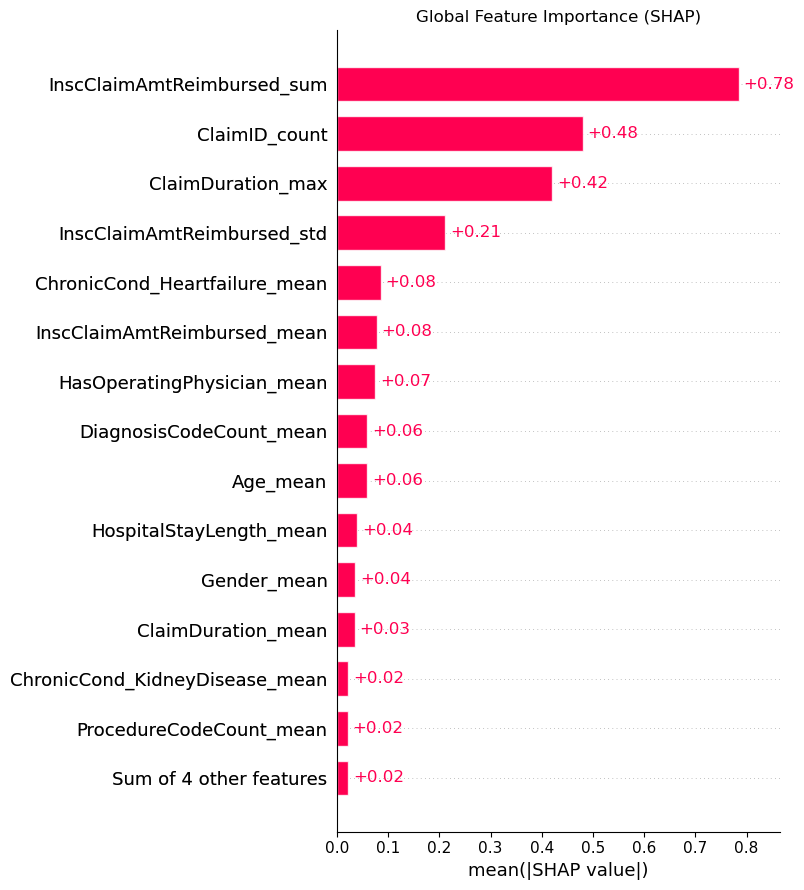

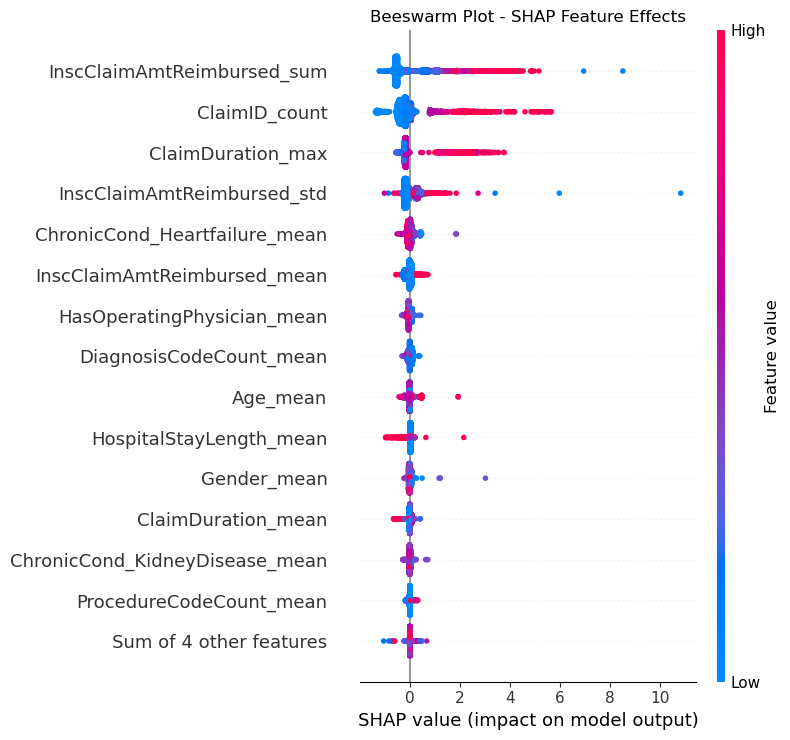

In [98]:
# Ensure directory for saving
os.makedirs("SHAP", exist_ok=True)

# ✅ Convert scaled data to DataFrame with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Create SHAP Explainer using named DataFrame
explainer = shap.Explainer(model, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df)

# 📊 Bar Plot: Global Feature Importance
plt.figure(figsize=(10, 4))
shap.plots.bar(shap_values, max_display=15, show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.savefig("SHAP/shap_summary_bar_plot.png")
plt.show()

# 🐝 Beeswarm Plot: Feature Impact Distributions
plt.figure(figsize=(10, 4))
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.title("Beeswarm Plot - SHAP Feature Effects")
plt.tight_layout()
plt.savefig("SHAP/shap_beeswarm_plot.png")
plt.show()


## 🧠 SHAP-Based Model Interpretation (Feature-Level)

To improve the transparency of our Gradient Boosting model, we use **SHAP (Shapley Additive Explanations)** to evaluate which features drive the predictions of potential fraud.

We visualized this using two plots: a **global feature importance chart** and a **beeswarm plot**


### 📊 Global Feature Importance — SHAP Summary Bar Plot

This bar chart shows the **average absolute SHAP values** for each feature, giving us a clear picture of which features are most influential overall.

Top features:
- **InscClaimAmtReimbursed_sum**: Total reimbursement amount is the most powerful indicator of fraud risk. Higher totals correlate with higher predicted fraud.
- **ClaimID_count**: The number of claims per provider is another strong signal - fraudulent providers often submit an unusually high number of claims.
- **ClaimDuration_max**: The longest claim duration among a provider's claims also contributes significantly, possibly indicating manipulation of hospitalization records.
- **InscClaimAmtReimbursed_std**: High variability in reimbursement amounts may signal inconsistent billing practices.
- **ChronicCond_Heartfailure_mean**: Prevalence of certain chronic conditions (e.g., heart failure) slightly increases fraud risk, potentially due to overbilling related to comorbidities.


### Beeswarm Plot — SHAP Feature Impact Distribution

The beeswarm plot shows **how feature values affect each individual prediction** and whether they push it toward fraud (`+`) or not (`-`).

Key insights:
- **InscClaimAmtReimbursed_sum** and **ClaimID_count**:
  - High values (in red) significantly increase fraud probability.
  - Low values (in blue) tend to reduce fraud suspicion.
- **ClaimDuration_max**:
  - Longer claim durations (red) generally push predictions toward fraud.
- **HasOperatingPhysician_mean** and **DiagnosisCodeCount_mean**:
  - These influence model decisions in more nuanced ways depending on the provider’s profile.


## ✅ Conclusion & Business Recommendations

This project successfully built a scalable, explainable pipeline for detecting **potential healthcare provider fraud** using real-world Medicare claims data.

### 🔍 Key Accomplishments
- Designed a comprehensive data pipeline for **merging**, **cleaning**, and **feature engineering** across multiple raw files (inpatient, outpatient, beneficiary, and labels).
- Focused on **data quality** by imputing missing values using Iterative Imputer and treating outliers post-aggregation.
- Aggregated claim-level data to the **provider level**, aligning with the goal of identifying fraudulent providers rather than individual claims.
- Applied **multiple machine learning models** with hyperparameter tuning. The **Gradient Boosting model** delivered the best balance of performance and interpretability.
- Used **SHAP** to visualize global and local feature impact, enabling transparency — crucial in sensitive domains like healthcare.

### 📊 Business Takeaways
- Providers with unusually high reimbursement totals, frequent claim submissions, and irregular claim durations should be prioritized for **audit or further investigation**.
- Features such as the prevalence of certain chronic conditions or variation in claim patterns also help signal suspicious behavior.
- This fraud detection system can serve as an **early warning tool**, helping government agencies or insurance companies prioritize investigations.

### 💡 Future Work
- Incorporate **time-series modeling** to detect fraud patterns over time.
- Use **unsupervised learning** for anomaly detection where labels are unavailable.
- Integrate domain expertise (e.g., billing codes, treatment plausibility) to enrich feature design.

> This project demonstrates how machine learning, paired with proper data engineering and interpretability tools, can uncover hidden patterns and support ethical, data-driven decision-making in high-risk industries.
